In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision.transforms.functional as F
import skimage.io as sio
from pycocotools import mask as mask_utils
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt
import random
import colorsys
from tqdm import tqdm
import json
import cv2
from torchvision.transforms import ToTensor
from pycocotools import mask as coco_mask
from torchvision.ops import nms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
def decode_maskobj(mask_obj):
    return mask_utils.decode(mask_obj)

def read_maskfile(filepath):
    return sio.imread(filepath)

In [ ]:
class CellMaskDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.samples = [os.path.join(root_dir, d) for d in os.listdir(root_dir)
                        if os.path.isdir(os.path.join(root_dir, d))]

    def __len__(self):
        return len(self.samples)

    def get_bounding_box(self, mask):
        pos = np.where(mask)
        if pos[0].size == 0 or pos[1].size == 0:
            return None
        x_min = np.min(pos[1])
        y_min = np.min(pos[0])
        x_max = np.max(pos[1])
        y_max = np.max(pos[0])
        if x_max <= x_min or y_max <= y_min:
            return None
        return [x_min, y_min, x_max, y_max]

    def __getitem__(self, idx):
        sample_path = self.samples[idx]
        image_path = os.path.join(sample_path, "image.tif")
        image = np.array(Image.open(image_path).convert("RGB"))

        masks = []
        boxes = []
        labels = []

        for class_id in range(1, 5):  # class1.tif to class4.tif
            mask_path = os.path.join(sample_path, f"class{class_id}.tif")
            if not os.path.exists(mask_path):
                continue

            full_mask = read_maskfile(mask_path)
            if full_mask.max() == 0:
                continue

            labeled_mask, num_instances = ndimage.label(full_mask)
            for inst_id in range(1, num_instances + 1):
                instance_mask = (labeled_mask == inst_id).astype(np.uint8)
                box = self.get_bounding_box(instance_mask)
                if box is None:
                    continue

                masks.append(instance_mask)
                boxes.append(box)
                labels.append(class_id)

        # Handle no-object case
        if not boxes:
            boxes = np.zeros((0, 4), dtype=np.float32)
            masks = np.zeros((0, image.shape[0], image.shape[1]),
                             dtype=np.uint8)
            labels = np.zeros((0,), dtype=np.int64)
        else:
            masks = np.stack(masks)
            boxes = np.array(boxes, dtype=np.float32)
            labels = np.array(labels, dtype=np.int64)

        # === Apply augmentations ===
        if self.transforms:
            transformed = self.transforms(image=image, masks=list(masks),
                                          bboxes=boxes, class_labels=labels)
            image = transformed['image']
            masks = torch.stack([torch.as_tensor(m, dtype=torch.uint8)
                                 for m in transformed['masks']])
            boxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            labels = torch.as_tensor(transformed['class_labels'],
                                     dtype=torch.int64)
        else:
            image = F.to_tensor(image)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([idx]),
        }

        return image, target

In [ ]:
def get_instance_segmentation_model(num_classes):
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [5]:
def apply_augmentations(image, target):
    if random.random() < 0.5:
        # Horizontal flip
        image = F.hflip(image)
        width = image.width
        if "boxes" in target:
            boxes = target["boxes"]
            boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
            target["boxes"] = boxes
        if "masks" in target:
            target["masks"] = F.hflip(target["masks"])
    return image, target

In [ ]:
def train_model(model, dataloader, device, epochs=10):
    # === Anchor Generator Customization ===
    model.rpn.anchor_generator.sizes = (
        (8, 16),
        (32, 64),
        (128,),
        (256,),
        (512, 1024)
    )
    model.rpn.anchor_generator.aspect_ratios = ((0.5, 1.0, 2.0),) *\
        len(model.rpn.anchor_generator.sizes)
    model.rpn.post_nms_top_n_train = 4000
    model.rpn.post_nms_top_n_test = 1500
    model.rpn.nms_thresh = 0.9
    model.roi_heads.score_thresh = 0.5

    model.train()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=0.001,
                                momentum=0.9,
                                weight_decay=0.0005)
    loss_values = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        print(f"\nEpoch {epoch + 1}/{epochs}")
        progress_bar = tqdm(dataloader, desc="Training", leave=False)

        for images, targets in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()}
                       for t in targets]

            # Forward + Backprop
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            loss_value = losses.item()
            epoch_loss += loss_value
            progress_bar.set_postfix(loss=loss_value)

        avg_loss = epoch_loss / len(dataloader)
        loss_values.append(avg_loss)
        print(f"Epoch {epoch + 1} completed. Avg Loss: {avg_loss:.4f}")

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(),
                       f'model_checkpoint_{epoch+1}_augmentation.pth')

    torch.save(model.state_dict(),
               'model_checkpoint_final_augmentation.pth')

    # Plot loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1),
             loss_values,
             marker='o',
             markersize=4,
             label='Avg Epoch Loss')
    plt.title("Learning Curve (Loss vs. Epoch)")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.xticks(range(1, epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.savefig("learning_curve_epochwise.png")
    plt.show()

In [ ]:
def random_colors(N):
    hsv = [(i / N, 1, 1) for i in range(N)]
    return [tuple(int(c * 255) for c in colorsys.hsv_to_rgb(*color))
            for color in hsv]

In [ ]:
def visualize_predictions(model, dataset, device, score_thresh=0.5):
    model.eval()
    colors = random_colors(5)
    with torch.no_grad():
        img, _ = dataset[0]
        prediction = model([img.to(device)])[0]

        img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(img_np)

        for i in range(len(prediction["scores"])):
            score = prediction["scores"][i].item()
            if score < score_thresh:
                continue

            mask = prediction["masks"][i, 0].cpu().numpy() > 0.5
            color = colors[prediction["labels"][i].item() % len(colors)]

            ax.contour(mask, colors=[np.array(color) / 255], linewidths=1)
            box = prediction["boxes"][i].cpu().numpy().astype(int)
            ax.add_patch(plt.Rectangle((box[0], box[1]),
                                       box[2] - box[0],
                                       box[3] - box[1],
                                       edgecolor=np.array(color) / 255,
                                       facecolor='none', lw=2))

        plt.axis('off')
        plt.show()

/home/jychpr/miniconda3/envs/kez-hw3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jychpr/miniconda3/envs/kez-hw3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/50


Epoch 1 completed. Avg Loss: 1.8680

Epoch 2/50


Epoch 2 completed. Avg Loss: 1.4338

Epoch 3/50


Epoch 3 completed. Avg Loss: 1.3318

Epoch 4/50


Epoch 4 completed. Avg Loss: 1.2641

Epoch 5/50


Epoch 5 completed. Avg Loss: 1.2300

Epoch 6/50


Epoch 6 completed. Avg Loss: 1.1995

Epoch 7/50


Epoch 7 completed. Avg Loss: 1.1622

Epoch 8/50


Epoch 8 completed. Avg Loss: 1.1543

Epoch 9/50


Epoch 9 completed. Avg Loss: 1.1367

Epoch 10/50


Epoch 10 completed. Avg Loss: 1.1287

Epoch 11/50


Epoch 11 completed. Avg Loss: 1.1099

Epoch 12/50


Epoch 12 completed. Avg Loss: 1.1282

Epoch 13/50


Epoch 13 completed. Avg Loss: 1.0825

Epoch 14/50


Epoch 14 completed. Avg Loss: 1.0583

Epoch 15/50


Epoch 15 completed. Avg Loss: 1.0506

Epoch 16/50


Epoch 16 completed. Avg Loss: 1.0376

Epoch 17/50


Epoch 17 completed. Avg Loss: 1.0109

Epoch 18/50


Epoch 18 completed. Avg Loss: 1.0138

Epoch 19/50


Epoch 19 completed. Avg Loss: 0.9981

Epoch 20/50


Epoch 20 completed. Avg Loss: 0.9981

Epoch 21/50


Epoch 21 completed. Avg Loss: 0.9986

Epoch 22/50


Epoch 22 completed. Avg Loss: 0.9736

Epoch 23/50


Epoch 23 completed. Avg Loss: 0.9598

Epoch 24/50


Epoch 24 completed. Avg Loss: 0.9529

Epoch 25/50


Epoch 25 completed. Avg Loss: 0.9627

Epoch 26/50


Epoch 26 completed. Avg Loss: 0.9569

Epoch 27/50


Epoch 27 completed. Avg Loss: 0.9518

Epoch 28/50


Epoch 28 completed. Avg Loss: 0.9287

Epoch 29/50


Epoch 29 completed. Avg Loss: 0.9194

Epoch 30/50


Epoch 30 completed. Avg Loss: 0.9415

Epoch 31/50


Epoch 31 completed. Avg Loss: 0.9081

Epoch 32/50


Epoch 32 completed. Avg Loss: 0.9038

Epoch 33/50


Epoch 33 completed. Avg Loss: 0.8917

Epoch 34/50


Epoch 34 completed. Avg Loss: 0.9024

Epoch 35/50


Epoch 35 completed. Avg Loss: 0.8839

Epoch 36/50


Epoch 36 completed. Avg Loss: 0.8807

Epoch 37/50


Epoch 37 completed. Avg Loss: 0.8677

Epoch 38/50


Epoch 38 completed. Avg Loss: 0.8757

Epoch 39/50


Epoch 39 completed. Avg Loss: 0.8454

Epoch 40/50


Epoch 40 completed. Avg Loss: 0.8342

Epoch 41/50


Epoch 41 completed. Avg Loss: 0.8529

Epoch 42/50


Epoch 42 completed. Avg Loss: 0.8686

Epoch 43/50


Epoch 43 completed. Avg Loss: 0.8466

Epoch 44/50


Epoch 44 completed. Avg Loss: 0.8415

Epoch 45/50


Epoch 45 completed. Avg Loss: 0.8338

Epoch 46/50


Epoch 46 completed. Avg Loss: 0.8226

Epoch 47/50


Epoch 47 completed. Avg Loss: 0.8120

Epoch 48/50


Epoch 48 completed. Avg Loss: 0.8175

Epoch 49/50


Epoch 49 completed. Avg Loss: 0.8135

Epoch 50/50


Epoch 50 completed. Avg Loss: 0.8201


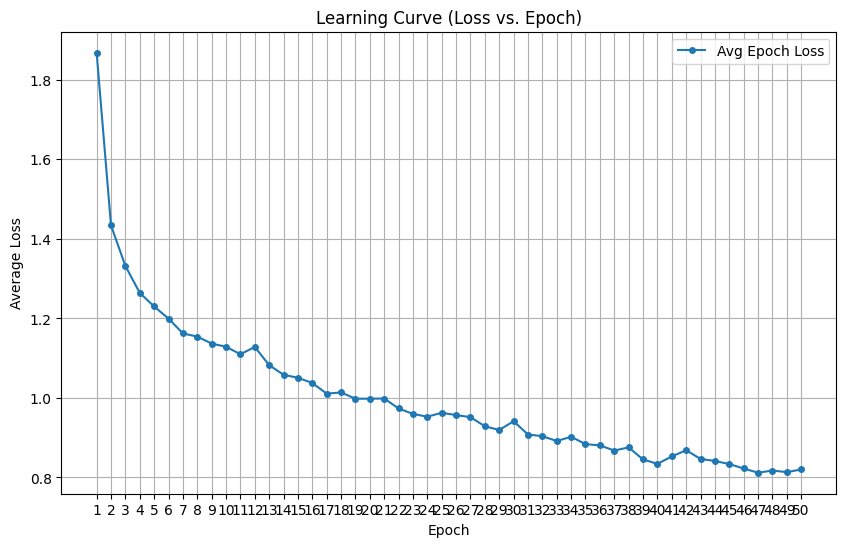

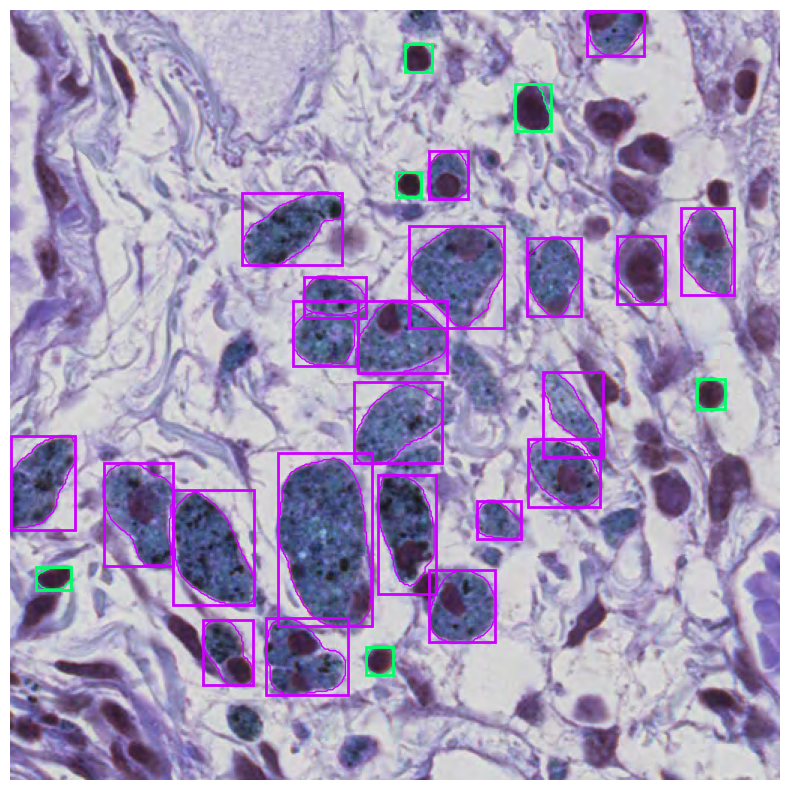

In [ ]:
# Main script
device = torch.device('cuda') if torch.cuda.is_available()\
    else torch.device('cpu')

# Dataset and loader
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ToFloat(max_value=255.0),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc',
                            label_fields=['class_labels']))

dataset = CellMaskDataset("/home/jychpr/JC/kez-hw3/hw3-data-release/train/",
                          transforms=train_transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True,
                         collate_fn=lambda x: tuple(zip(*x)))

# Model
num_classes = 5  # 4 cell classes + background
model = get_instance_segmentation_model(num_classes)
model.to(device)

# Train
train_model(model, data_loader, device, epochs=50)

# Inference
visualize_predictions(model, dataset, device)

In [ ]:
def map_id(filename):
    map_json_path =\
        "/home/jychpr/JC/kez-hw3/hw3-data-release/test_image_name_to_ids.json"
    with open(map_json_path, "r") as f:
        data = json.load(f)

    for d in data:
        if filename == d['file_name']:
            return d['id']

In [ ]:
# === Category mapping ===
category_id_to_name = {
    1: "class1",
    2: "class2",
    3: "class3",
    4: "class4",
}

# === Setup ===
num_classes = 5  # background + 4 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_instance_segmentation_model(num_classes)
model.load_state_dict(torch.load("model_checkpoint_final_augmentation.pth",
                                 map_location=device))
model.to(device)
model.eval()

# === Image dir ===
image_dir = "/home/jychpr/JC/kez-hw3/hw3-data-release/test_release"
image_filenames = sorted(os.listdir(image_dir))
transform = ToTensor()
coco_results = []

def encode_mask(mask):
    rle = coco_mask.encode(np.asfortranarray(mask.astype(np.uint8)))
    rle["counts"] = rle["counts"].decode("utf-8")
    return rle

for image_id, image_file in enumerate(image_filenames):
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).to(device)

    # === TTA: Original + Horizontal Flip ===
    with torch.no_grad():
        original_output = model([image_tensor])[0]
        # Horizontal flip (width)
        flipped_image_tensor = torch.flip(image_tensor, dims=[2])
        flipped_output = model([flipped_image_tensor])[0]

    # === Flip boxes and masks back ===
    w = image_tensor.shape[2]

    flipped_boxes = flipped_output['boxes'].clone()
    flipped_boxes[:, [0, 2]] = w - flipped_boxes[:, [2, 0]]
    # Flip width back
    flipped_masks = torch.flip(flipped_output['masks'], dims=[3])

    # === Merge outputs ===
    boxes = torch.cat([original_output['boxes'], flipped_boxes.to(device)])
    scores = torch.cat([original_output['scores'], flipped_output['scores']])
    labels = torch.cat([original_output['labels'], flipped_output['labels']])
    masks = torch.cat([original_output['masks'], flipped_masks.to(device)])

    # === NMS to filter duplicates ===
    keep = nms(boxes, scores, iou_threshold=0.5)
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]
    masks = masks[keep]

    # === Visualization and COCO saving ===
    image_np = np.array(image).copy()

    for i in range(len(boxes)):
        score = scores[i].item()
        if score < 0.5:
            continue

        box = boxes[i].cpu().numpy()
        label = int(labels[i].item())
        mask = masks[i, 0].cpu().numpy() > 0.5

        x1, y1, x2, y2 = box
        bbox = [float(x1), float(y1), float(x2 - x1), float(y2 - y1)]

        rle = encode_mask(mask)

        coco_results.append({
            "image_id": map_id(image_file),
            "category_id": label,
            "bbox": bbox,
            "score": float(score),
            "segmentation": rle
        })

        # Visualization
        color = np.random.randint(0, 255, (3,), dtype=np.uint8)
        image_np[mask] = image_np[mask] * 0.5 + color * 0.5

        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image_np, (x1, y1), (x2, y2), color.tolist(), 2)
        label_name = category_id_to_name.get(label, str(label))
        cv2.putText(image_np, f"{label_name}: {score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color.tolist(), 2)

    # === Show or save image ===
    plt.figure(figsize=(5, 5))
    plt.imshow(image_np)
    plt.title(image_file)
    plt.axis("off")
    plt.show()

# === Save COCO-format results ===
with open("predictions_coco_format_tta_augmentation.json", "w") as f:
    json.dump(coco_results, f)

print("Saved predictions with TTA to\
      predictions_coco_format_tta_augmentation.json")